# WRF perturbations

In [2]:
%cd ~/git/wrf_lrf_les/

/home/561/tr2908/git/wrf_lrf_les


In [3]:
import sys

sys.path.append("analysis/")

import modules.wrf_perturbation as wp
from dask.distributed import Client
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

print("Report last updated at " + str(datetime.datetime.now()) + " UTC.")

Report last updated at 2024-07-11 10:46:28.332234 UTC.


Start a dask cluster for parallel processing.

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 28,Total memory: 125.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38841,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 125.18 GiB
Comm: tcp://127.0.0.1:39849,Total threads: 4
Dashboard: http://127.0.0.1:35141/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:43353,


## Settings

In [221]:
# Directories for results to read.
dirs = {"1 km": "1km", "4 km": "4km", "100 m": "LES"}

# The point at which the RCE run ends and control + perturbation runs begin.
runs_start = {
    "4 km": "2000-03-01",
    "1 km": "2000-03-01",
    "1 km np": "2000-03-01",
    "100 m": "2000-04-25",
}

# Start and end times for designated RCE periods.
RCE_times = {
    "4 km": ["2000-04-01", "2000-06-01"],
    "1 km": ["2000-04-01", "2000-06-01"],
    "1 km np": ["2000-04-01", "2000-06-01"],
    "100 m": ["2000-05-01", "2000-05-04"],
}

# Perturbation details.
perts = {
    "res": list(dirs.keys()),  # Dataset names.
    "dir": [dirs[x] for x in dirs.keys()],  # Dataset directories.
    "levels": ["850", "730", "600", "500", "412"],  # Perturbed levels in hPa.
    "T": ["0.5", "-0.5"],  # Temperature perturbations in K day-1.
    "q": ["0.0002", "-0.0002"],
}  # Specific humidity perturbations in kg kg-1 day-1.

# Input directories with dataset names as keys.
basedir = "/g/data/up6/tr2908/em_quarter_ss/v4.1.4/output/"
inputs = wp.input_map(perts=perts, basedir=basedir)

# Figure settings.
plt.rcParams["figure.figsize"] = wp.FIGURE_SIZE  # Figure size for non-facetted plots.
plt.rcParams["font.size"] = 14  # Font size for plots.
plt.rcParams["axes.formatter.useoffset"] = False  # Don't use offsets in plots.

plot_levels = [850, 500, 410, 100]  # Pressure levels to plot individually [hPa].

## Read data

The script `~/code/sh/extract_WRF_variables_parallel.sh` runs, in parallel, a python script that extracts variables of interest from WRF `wrfout` files, optionally interpolates the 3D variables to vertical pressure levels, and takes spatial means across horizontal dimensions. These profiles of mean values per time are written to `wrfvar` files, which are then opened here. Note results are cached in `data/WRF`.

In [7]:
wrf_pw_ts, wrf_profs = wp.load_cache_data(
    inputs=inputs, dirs=dirs, runs_start=runs_start, RCE_times=RCE_times
)

Calculate WRF responses to perturbations.

In [8]:
wrf_responses = wp.WRF_responses(profs=wrf_profs)

Read MONC data:

In [45]:
monc_cwv = wp.MONC_CWV_data()
monc_responses = wp.MONC_response_data()

Collect responses into one DataFrame:

In [10]:
all_responses = wp.concat_diffs(responses=[wrf_responses, monc_responses])

Read reference data from Kuang et al.

In [11]:
ref_responses = wp.kuang_data(ref_dir="/g/data/up6/tr2908/LRF_SCM_results/")

## Radiative-convective equilibrium (RCE)

To determine when the simulations have reached RCE, we look for stabilisation of the precipitable water (PW) field. Here is spatially-averaged PW by time for each simulation in WRF. The green highlighted region is the time span over which average profiles are calculated for all runs. MONC is also included here.

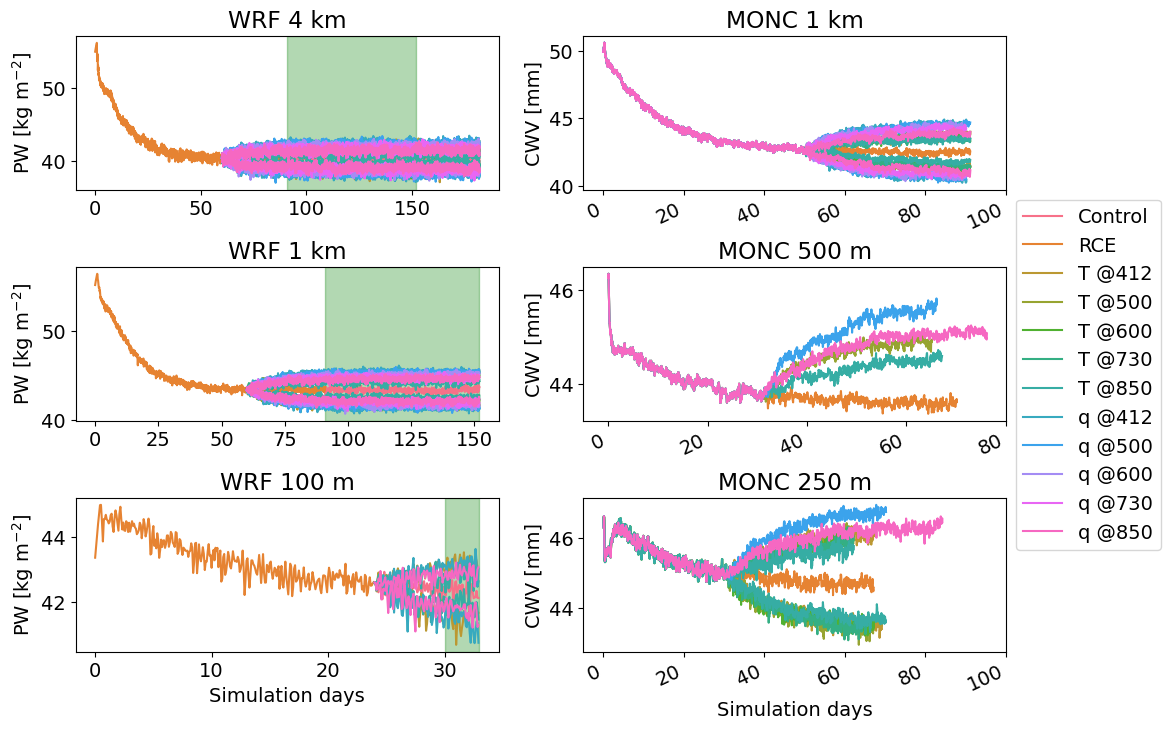

In [222]:
reload(wp)
wp.plot_ts_wrf_monc(
    wrf_pw_ts=wrf_pw_ts,
    monc_cwv=monc_cwv,
    WRF_RCE_times=RCE_times,
    file='paper/figures/runs_timeseries.pdf',
)

## Mean profiles over RCE period

In [266]:
reload(wp)
monc_ctrl_profs = wp.read_MONC_profs()
wrf_ctrl_profs = pd.concat([wrf_profs[x].sel(Dataset="Control").to_dataframe().drop(columns='Dataset').assign(res=x, model='WRF') for x in wrf_profs])
wrf_ctrl_profs = wrf_ctrl_profs.reset_index()

# Convert wrf mixing ratios to g kg-1.
wrf_ctrl_profs['q'] = wrf_ctrl_profs.q * 1000
wrf_ctrl_profs['q'] = wrf_ctrl_profs.q * 1000
wrf_ctrl_profs['qcloud'] = wrf_ctrl_profs.qcloud * 1000
wrf_ctrl_profs['qice'] = wrf_ctrl_profs.qice * 1000
wrf_ctrl_profs['qsnow'] = wrf_ctrl_profs.qsnow * 1000
wrf_ctrl_profs['qrain'] = wrf_ctrl_profs.qrain * 1000
wrf_ctrl_profs['qgraup'] = wrf_ctrl_profs.qgraup * 1000

profs = pd.concat([wrf_ctrl_profs, monc_ctrl_profs])
profs = profs.rename(columns={'res': 'Resolution', 'model': 'Model'})

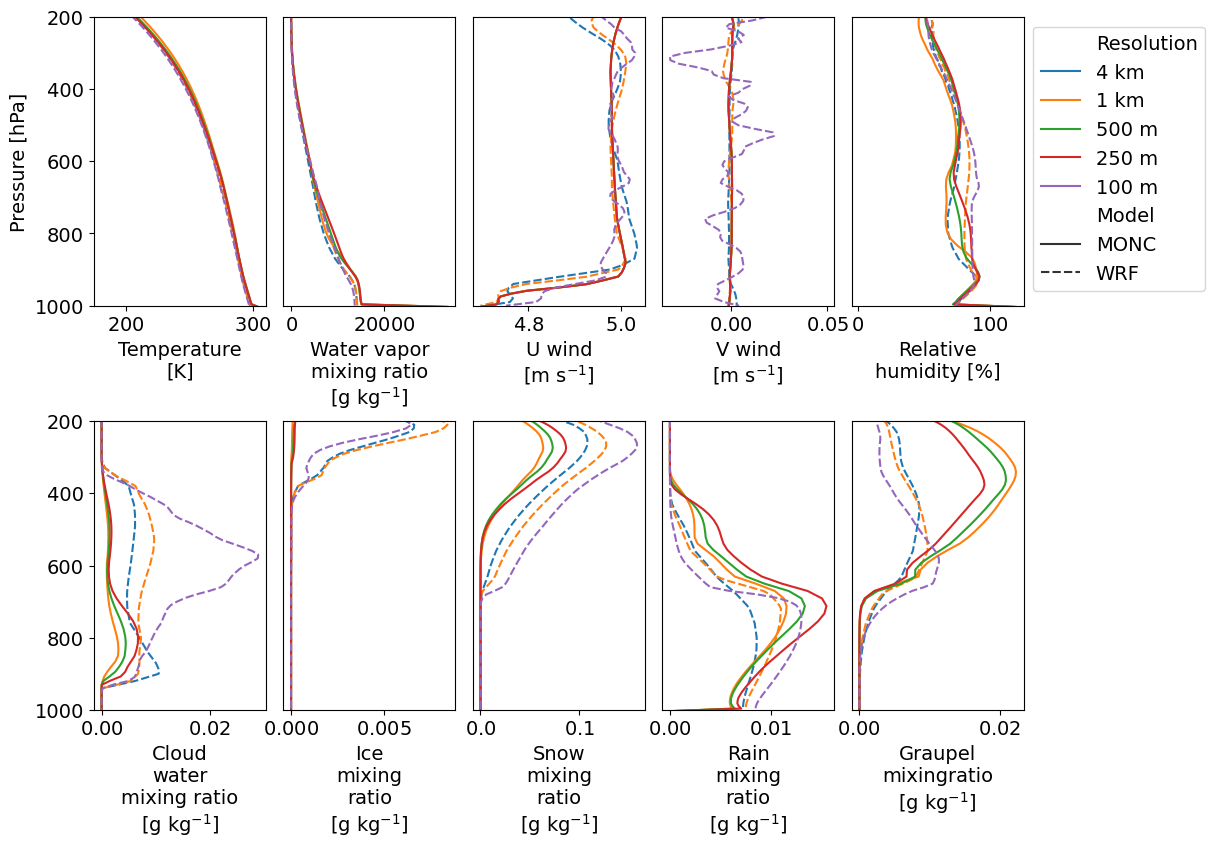

In [267]:
reload(wp)
wp.plot_mean_profiles(
    profs=profs,
    variables=['tk', 'q', 'ua', 'va', 'rh', 'qcloud', 'qice', 'qsnow', 'qrain', 'qgraup'],
    relabel={
        'tk': 'Temperature\n[K]',
        'q': 'Water vapor\nmixing ratio\n[g kg$^{-1}$]',
        'ua': 'U wind\n[m s$^{-1}$]',
        'va': 'V wind\n[m s$^{-1}$]',
        'rh': 'Relative\nhumidity [%]',
        'qcloud': 'Cloud\nwater\nmixing ratio\n[g kg$^{-1}$]',
        'qice': 'Ice\nmixing\nratio\n[g kg$^{-1}$]',
        'qsnow': 'Snow\nmixing\nratio\n[g kg$^{-1}$]',
        'qrain': 'Rain\nmixing\nratio\n[g kg$^{-1}$]',
        'qgraup': 'Graupel\nmixingratio\n[g kg$^{-1}$]',
    },
    file='paper/figures/rce_profiles.pdf',
    figsize=(12,9)
)

## Differences in averaged RCE profiles

Differences here are defined as `perturbed - control`. The red vertical line shows zero difference.

In [ ]:
# Hydrometeor classes for MONC at 500 and 250 m are in 1000 * g kg-1.
# lores = monc[~np.logical_or(monc.res == '500 m',
#                            monc.res == '250 m')].copy()
# hires = monc[np.logical_or(monc.res == '500 m',
#                            monc.res == '250 m')].copy()
# for particle in ['qcloud', 'qice', 'qsnow', 'qrain', 'qgraup']:
#     hires[particle] = hires[particle].copy() / 1000
# monc = pd.concat([lores, hires])

In [ ]:
def plot_responses(
    responses,
    refs=ref_responses,
    hue_order=["4 km", "1 km", "500 m", "250 m", "100 m"],
    variables=["tk", "rh", "q", "qcloud", "qice", "qsnow", "qrain", "qgraup"],
    var_labels={
        "tk": "Temperature\n[K]",
        "rh": "RH\n[%]",
        "q": "MR Vapour\n[10$^{-3}$ g kg$^{-1}$]",
        "qcloud": "MR Cloud\n[10$^{-3}$ g kg$^{-1}$]",
        "qice": "MR Ice\n[10$^{-3}$ g kg$^{-1}$]",
        "qsnow": "MR Snow\n[10$^{-3}$ g kg$^{-1}$]",
        "qrain": "MR Rain\n[10$^{-3}$ g kg$^{-1}$]",
        "qgraup": "MR Graupel\n[10$^{-3}$ g kg$^{-1}$]",
    },
    figsize=(12, 8),
    ncols=4,
    nrows=2,
    hspace=0.3,
    wspace=0.1,
    min_pressure=200,
    show_negs=False,
):
    assert len(variables) <= ncols * nrows, "Not enough col/rows."
    perts = [x for x in np.unique(responses.pert_group)]
    for p in perts:
        p_level = float(p[-3:])

        fig, axs = plt.subplots(
            ncols=ncols,
            nrows=nrows,
            figsize=figsize,
            gridspec_kw={"hspace": hspace, "wspace": wspace},
        )
        d = responses[responses.pert_group == p]
        d = d[d.pressure >= min_pressure]

        for i, variable in enumerate(variables):
            axs.flat[i].axvline(0, color="black")
            axs.flat[i].axhline(p_level, color="black", linestyle="--")

            sns.lineplot(
                data=d[~d.neg],
                x=variable,
                y="pressure",
                ax=axs.flat[i],
                style="Model",
                hue="Resolution",
                sort=False,
                estimator=None,
                legend=(i == ncols - 1),
                hue_order=hue_order[::-1],
                palette=sns.color_palette("turbo", len(hue_order)),
                zorder=5,
            )

            if len(d[d.neg]) > 0 and show_negs:
                sns.lineplot(
                    data=d[d.neg],
                    x=variable,
                    y="pressure",
                    ax=axs.flat[i],
                    style="Model",
                    hue="Resolution",
                    sort=False,
                    estimator=None,
                    legend=False,
                    hue_order=hue_order[::-1],
                    alpha=0.5,
                    palette=sns.color_palette("turbo", len(hue_order)),
                    zorder=5,
                )

            axs.flat[i].invert_yaxis()
            axs.flat[i].set_ylim(1000, min_pressure)

            # Add Kuang 2010 reference values.
            if variable == "q":
                r = refs[refs.Dataset == p]
                axs.flat[i].scatter(
                    r.q * 1000,
                    r.level,
                    facecolors="none",
                    edgecolors="black",
                    zorder=10,
                    s=30,
                )
            if variable == "tk":
                r = refs[refs.Dataset == p]
                axs.flat[i].scatter(
                    r.tk,
                    r.level,
                    facecolors="none",
                    edgecolors="black",
                    zorder=10,
                    s=30,
                )

            # Relabel axes if required.
            if variable in var_labels:
                axs.flat[i].set_xlabel(var_labels[variable])

            # Handle ticks.
            if i % ncols == 0:
                axs.flat[i].set_ylabel("Pressure [hPa]")
            else:
                axs.flat[i].set_ylabel("")
                axs.flat[i].set_yticks([])

        sns.move_legend(axs.flat[ncols - 1], "upper left", bbox_to_anchor=(1, 1))
        _ = plt.suptitle(p, y=0.93)
        # plt.savefig(f'paper/figures/pert_diffs_{p.replace(" ", "_")}.pdf', bbox_inches='tight')
        plt.show()
        # plt.close()

In [ ]:
plot_responses(
    responses=all_responses,
    hue_order=["4 km", "1 km", "500 m", "250 m", "100 m"],
    show_negs=True,
)

In [ ]:
# for v in ['T', 'q']:
#     for res in wrfvars.keys():
#         ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
#         sub = profs[res].sel(Dataset=ds)
#         diffs = wp.calc_profile_diffs(profs=sub, neg=[x for x in ds if '-' in x])
#         break
#     break

In [ ]:
# for v in ['T', 'q']:
#     for res in wrfvars.keys():
#         ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
#         sub = profs[res].sel(Dataset=ds)
#         wp.compare_profiles(profs=sub, figsize=[13.5,5], neg=[x for x in ds if '-' in x],
#                             title=(res + ', perturbed ' + v + ' (RCE: ' + str(start_time[res]) +
#                                    ' to ' + str(end_time[res]) + ')'),
#                             xlims={'tk': [-0.1,1.2],
#                                    'q': [-0.00025, 0.0005],
#                                    'rh': [-4, 7]})
#         break
#     break

In [ ]:
# for v in ['T', 'q']:
#     for res in wrfvars.keys():
#         ds = ['Control'] + [x for x in profs[res].Dataset.values if x[0] == v]
#         sub = profs[res].sel(Dataset=ds)
#         wp.compare_profiles(profs=sub, figsize=[13.5,5], neg=[x for x in ds if '-' in x],
#                             variables=['conv_mass_flux', 'wa'],
#                             title=(res + ', perturbed ' + v + ' (RCE: ' + str(start_time[res]) +
#                                    ' to ' + str(end_time[res]) + ')'),
#                             xlims={'conv_mass_flux': [-0.011, 0.005],
#                                    'wa': [-0.0002, 0.0003]})

## Extra scripts

In [ ]:
# direc = '/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/1km/pert_412hPa_q_-0.0002kgkg-1/'
# d = xarray.open_mfdataset(direc + 'wrfout*', concat_dim='Time', combine='nested')
#
# theta = d.T + 300
# p = (d.P + d.PB) / 100
# q = d.QVAPOR
#
# import modules.atmosphere as at
# rh = at.relative_humidity(theta=theta, p=p, q=q)
#
# minval_all = np.round(rh.min().values, 2)
# maxval_all = np.round(rh.max().values, 2)
# minval_trop = np.round(rh.where(p > 160).min().values, 2)
# maxval_trop = np.round(rh.where(p > 160).max().values, 2)
#
# rh.plot.hist(bins=80, label='All data', histtype='step', density=True)
# rh.where(p > 160).plot.hist(bins=80, label='> 160 hPa', histtype='step', density=True)
# plt.title('Distributions as densities\nAll data range: ' + str(minval_all) + '% to ' + str(maxval_all) +
#          '%\n> 160 hPa range: ' +
#          str(minval_trop) + '% to ' + str(maxval_trop) + '%')
# plt.legend()
# plt.show()

In [ ]:
# For computing shear profile from 1 km RCE pressure/height combinations.
#
# import xarray
# out = xarray.open_mfdataset(basedir + '1km/control/wrfout_d01_*', combine='nested', concat_dim='Time')
# pres = ((out.P + out.PB) * 0.01).mean(['south_north', 'west_east','Time'])
# height = ((out.PH + out.PHB) / 9.81).mean(['south_north', 'west_east','Time'])
# height = (height[1:] + height[:-1]) / 2
# plt.plot(pres, height)

# from scipy import interpolate
# f = interpolate.interp1d(x=[pres.max(), 500, 160, pres.min()], y=[0,5,0,0])
# shear_prof = f(pres.values)

# plt.scatter(shear_prof, pres.values, color='black')
# plt.plot(shear_prof, pres.values)
# plt.gca().invert_yaxis()

# np.savetxt(basedir+'/U_profile.shear', shear_prof, fmt='%f')

In [ ]:
# Calculating shear for wind shear experiments -- to write to input_sounding and U_target files.

# import modules.rcemip_profile as rcemip
# import pandas as pd
# import xarray

# heights = rcemip.suggested_heights()
# sheared_U = wp.shear_profile(z=heights)

# # Update input sounding.
# d = pd.read_table('.../input_sounding.1km_shear', skiprows=1, names=['z', 'T', 'q', 'U', 'V'])
# d.U = sheared_U
# d.to_csv('/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/input_sounding.1km_shear2', sep='\t', index=False)

# # Also write U_target file to match.

# plt.plot(sheared_U, heights)
# plt.xlabel('U wind speed [m s-1]')
# plt.ylabel('Initial model height [m]')
# plt.gca().set_ylim([0,12000])
# plt.gca().set_xlim([0,25])
# plt.grid(which='both')
# plt.show()

# # Check wrfinput file.
# inp = xarray.open_dataset('/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/run/1km_shear/RCE/wrfinput_d01')
# inp.U.mean(['Time', 'south_north', 'west_east_stag'])

### TODO:

- Check which turbulence closure scheme was used. Rerun 1km runs with different turbulence scheme to see differences.
- Try to figure out why the domain is drying out at about 850 hPa. 